In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
class LinModel(nn.Module):
    def __init__(self):
        super(LinModel, self).__init__()
        self.lin1 = nn.Linear(1024*7*7, 4068)
        self.lin2 = nn.Linear(4068, 512)
        self.lin3 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

In [65]:
# lane_model = torch.load('saved_models/vgg16_pretained_2lane.pth',map_location='cuda:0')
# box_model = torch.load('saved_models/unet_pretrained_boxnet.pth',map_location='cuda:0')
lane_model = torch.load('saved_models/model-UnetResnet-3.pth',map_location='cuda:0')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [66]:
data_dir = '/home/anudeep/lane-detection/dataset'
data = pd.read_json(os.path.join(data_dir, 'label_data.json'), lines=True)
data.info()
print(len(data.raw_file))
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lanes      2855 non-null   object
 1   h_samples  2855 non-null   object
 2   raw_file   2855 non-null   object
dtypes: object(3)
memory usage: 67.0+ KB
2855


,lanes,h_samples,raw_file
0,"[[-100, -100, -100, -100, 632, 625, 617, 609, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-100, -100, -100, 658, 646, 635, 623, 612, 6...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-100, 570, 554, 538, 522, 505, 489, 473, 456...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-100, -100, -100, -100, 555, 542, 530, 517, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-100, -100, -100, 522, 525, 528, 531, 534, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg
...,...,...,...
2850,"[[-100, -100, -100, 595, 589, 583, 577, 571, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/26520/20.jpg
2851,"[[-100, -100, 728, 683, 651, 624, 608, 592, 57...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/30960/20.jpg
2852,"[[417, 435, 453, 471, 477, 478, 480, 481, 482,...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/23220/20.jpg
2853,"[[-100, -100, -100, -100, 440, 451, 458, 458, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/35300/20.jpg


Reading from:  /home/anudeep/lane-detection/dataset/clips/0313-1/52260/20.jpg


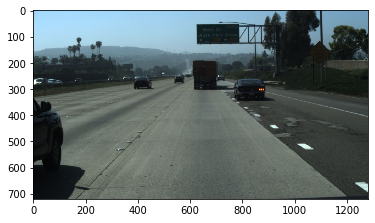

In [67]:
i=71
img_path = data.raw_file[i]
img_path = os.path.join(data_dir,img_path)
print('Reading from: ', img_path)
img_raw = cv2.imread(img_path)
img1 = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [68]:
# lane_model = lane_model.eval()

In [69]:
lane_model

UNetResnet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [88]:
img2 = cv2.imread('test_images/test5.jpg') 
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
img = cv2.resize(img2,(128,128), cv2.INTER_NEAREST)
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

In [89]:
pred = lane_model(torch.tensor(img).float().cuda())

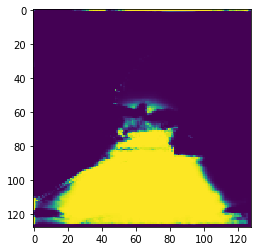

In [90]:
prediction = F.sigmoid(pred)
prediction = prediction.cpu().detach()
prediction = torch.squeeze(prediction)
plt.imshow(prediction)

In [82]:
p = prediction.numpy()
p = p*255
p = np.array(p, dtype= np.uint8)

In [83]:
ret, otsu = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

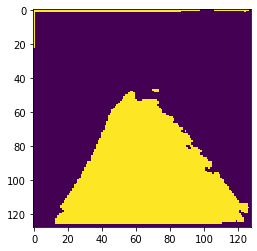

In [84]:
plt.imshow(otsu)